In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

def preprocess_words(x):
    example_sent = x.lower()
    stop_words = set(stopwords.words('english'))
    stop_words.add('regards')
    stop_words.add('thanks')
    tokenizer = RegexpTokenizer(r'\w+')
    word_tokens = tokenizer.tokenize(example_sent)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bd83e50>]], dtype=object)

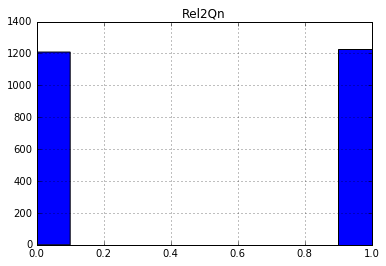

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

data = pd.read_json('cqa_task3.json')
data.head()
df_train = pd.io.json.json_normalize(data[0][1]['xml'][1]['Thread'])
df_comment = pd.concat([pd.DataFrame(pd.io.json.json_normalize(x)) for x in df_train['RelComment']],ignore_index=True)
df_comment['THREAD_SEQUENCE'] = [ '_'.join(i.split('_')[:2]) for i in df_comment['RELC_ID']]
df_train = pd.concat([df_train.set_index('THREAD_SEQUENCE'),df_comment.set_index('THREAD_SEQUENCE')], axis=1, join='inner').reset_index()
df_train.head()
rem_cols = ['RelQuestion.#text' , 'RelComment', 'RelCBody.#text.data' , 'RelQuestion.RelQBody.#text.data' , 
            'RelQuestion.RelQBody.#text.data', '#text','THREAD_SEQUENCE' ,'RelQuestion.RELQ_USERNAME','RELC_USERNAME']
[ df_train.drop(i, axis=1, inplace=True) for i in rem_cols  ]
df_train.columns = ['Q_category', 'Q_date' , 'Q_id', 'Q_user_id' , 'Q_textdata', 'Q_subject', 'C_date', 'C_id' ,'Rel2Qn' , 'C_user_id', 'C_textdata']
df_train.head()


#"Good"

df_train['Rel2Qn'] = df_train['Rel2Qn'].apply( lambda x: False if str(x) == "Bad"  else True)
df_train.head()
df_train.hist()

In [3]:
# EDA 
print "Length of dataframe", len(df_train)
print "Number of unique category  : ", df_train['Q_category'].nunique()
print "Number of unique subject : ", df_train['Q_subject'].nunique()
print "Number of unique subject : ", df_train['C_user_id'].nunique()

Length of dataframe 2440
Number of unique category  :  21
Number of unique subject :  243
Number of unique subject :  914


In [4]:
# Detailed anlysis of the Subject column in the train data
#groupby subject and find count
def remove_subject(row):
    x = row['Subject'].split(' ')
    y = row['tokenized_question'].split(' ')
    resultwords  = [word for word in y if word.lower() not in x]    
    return ' '.join(resultwords)


df_train['Subject'] = df_train['Q_subject'].apply( lambda x : preprocess_words(x))
df_train['tokenized_question'] = df_train['Q_textdata'].apply(lambda row: preprocess_words(str(''.join([c for c in row if ord(c) < 128]))))
df_train['tokenized_comment'] = df_train['C_textdata'].apply(lambda row: preprocess_words(str(''.join([c for c in row if ord(c) < 128]))))
df_train['tokenized_question'] = df_train.apply( lambda row : remove_subject(row) , axis=1)
df_temp = df_train.groupby('Q_subject').count()
df_temp.query("Q_category != 10 ")
df_train[df_train.Q_subject == "QP Offer" ]
df_train.head()
#  " QP Offer " -> has 20  subject


,Q_category,Q_date,Q_id,Q_user_id,Q_textdata,Q_subject,C_date,C_id,Rel2Qn,C_user_id,C_textdata,Subject,tokenized_question,tokenized_comment
0,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 06:46:39,Q268_R16_C1,False,U65,banks are using us ... Talk to those who had t...,best bank,hi ti ql using using affiliate home,banks using us talk taken credit card loan know
1,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 08:10:53,Q268_R16_C2,False,U956,In Qatar that is like saying which is the best...,best bank,hi ti ql using using affiliate home,qatar like saying best std
2,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 10:37:03,Q268_R16_C3,False,U5152,I'm surprised to see such feedbacks on Qatar b...,best bank,hi ti ql using using affiliate home,surprised see feedbacks qatar banks serious pr...
3,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-08-01 11:38:21,Q268_R16_C4,True,U5153,Well Arman; nothing is wrong here with banks; ...,best bank,hi ti ql using using affiliate home,well arman nothing wrong banks feel par uae ba...
4,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-08-01 11:45:49,Q268_R16_C5,True,U492,With QNB for last 4 years plus...no issues...g...,best bank,hi ti ql using using affiliate home,qnb last 4 years plus issues great service smi...


In [5]:
import gensim
from gensim import corpora
import math

class BM25 :
    def __init__(self, raw_data,delimiter='|') :
        self.dictionary = corpora.Dictionary()
        self.DF = {}
        self.delimiter = delimiter
        self.DocTF = []
        self.DocIDF = {}
        self.N = 0
        self.DocAvgLen = 0
        self.DocLen = []
        self.raw_data = []
        self.buildDictionary(raw_data)
        self.TFIDF_Generator(raw_data)

    def buildDictionary(self,raw_data) :
        '''
     For reading files and converting to data and add in documents
         raw_data = []
         for line in file(self.fn_docs) :
             raw_data.append(line.strip().split(self.delimiter))
        '''
        self.dictionary.add_documents(raw_data)

    def TFIDF_Generator(self, raw_data, base=math.e) :
        docTotalLen = 0
        for doc in raw_data :
#             doc = line.strip().split(self.delimiter) -- for converting from file 
            docTotalLen += len(doc)
            self.DocLen.append(len(doc))
            #print self.dictionary.doc2bow(doc)
            bow = dict([(term, freq*1.0/len(doc)) for term, freq in self.dictionary.doc2bow(doc)])
            for term, tf in bow.items() :
                if term not in self.DF :
                    self.DF[term] = 0
                self.DF[term] += 1
            self.DocTF.append(bow)
            self.N = self.N + 1
        for term in self.DF:
            self.DocIDF[term] = math.log((self.N - self.DF[term] +0.5) / (self.DF[term] + 0.5), base)
        self.DocAvgLen = docTotalLen / self.N

    def BM25Score(self, Query=[], k1=1.5, b=0.75) :
        query_bow = self.dictionary.doc2bow(Query)
        scores = []
        for idx, doc in enumerate(self.DocTF) :
            commonTerms = set(dict(query_bow).keys()) & set(doc.keys())
            tmp_score = []
            doc_terms_len = self.DocLen[idx]
            for term in commonTerms :
                upper = (doc[term] * (k1+1))
                below = ((doc[term]) + k1*(1 - b + b*doc_terms_len/self.DocAvgLen))
                tmp_score.append(self.DocIDF[term] * upper / below)
            scores.append(sum(tmp_score))
        return scores

    def TFIDF(self) :
        tfidf = []
        for doc in self.DocTF :
            doc_tfidf  = [(term, tf*self.DocIDF[term]) for term, tf in doc.items()]
            doc_tfidf.sort()
            tfidf.append(doc_tfidf)
        return tfidf

    def Items(self) :
        # Return a list [(term_idx, term_desc),]
        items = self.dictionary.items()
        items.sort()
        return items

# if __name__ == '__main__' :
#     #mycorpus.txt is as following:
#     '''
#     Human machine interface for lab abc computer applications
#     A survey of user opinion of computer system response time
#     The EPS user interface management system
#     System and human system engineering testing of EPS
#     Relation of user perceived response time to error measurement
#     The generation of random binary unordered trees
#     The intersection graph of paths in trees
#     Graph IV Widths of trees and well quasi ordering
#     Graph minors A survey
#     '''
#     fn_docs = 'mycorpus.txt'
#     raw_data = [['Human', 'machine', 'interface', 'for', 'lab', 'abc', 'computer', 'applications'],
#                 ['A', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time'], 
#                 ['The', 'EPS', 'user', 'interface', 'management', 'system'], 
#                 ['System', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS'], 
#                 ['Relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement'], 
#                 ['The', 'generation', 'of', 'random', 'binary', 'unordered', 'trees'], 
#                 ['The', 'intersection', 'graph', 'of', 'paths', 'in', 'trees'], 
#                 ['Graph', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering'],
#                 ['Graph', 'minors', 'A', 'survey']]
#     bm25 = BM25(raw_data, delimiter=' ')
#     print bm25
#     Query = 'What is a Graph ?'
#     Query = Query.split()
#     print Query
#     scores = bm25.BM25Score(Query)
#     #print "Len of scores",len(scores)
#     print "scores",scores
#     tfidf = bm25.TFIDF()
#     #print bm25.Items()
#     for i, tfidfscore in enumerate(tfidf):
#         print i, tfidfscore
                                 


In [6]:
convert_to_list = lambda x: x.split()
list_of_comments = list(map(convert_to_list,df_train.groupby('Q_id').get_group('Q269_R3')['tokenized_comment']))
print list(df_train.groupby('Q_id').get_group('Q269_R3')['tokenized_comment'])
qn_val = set(df_train.groupby('Q_id').get_group('Q269_R3')['tokenized_question']).pop()
bm25 = BM25(list_of_comments, delimiter=' ')
Query = preprocess_words(qn_val)
print " ---- Query is : --- ",Query
Query = Query.split()
scores = bm25.BM25Score(Query)
print "Scores",scores
# tfidf = bm25.TFIDF()
# print bm25.Items()
# for i, tfidfscore in enumerate(tfidf):
#     print i, tfidfscore

['dun u know green water much green underwater means much fish nearshore', 'catching fish corniche show photos would believe everything corniche banned fishing playing football bikes setting grass know next go khour el edid see actually open places guarantee time even area near ritz carlton going like 7 years fulling 2 big coleman fridges comes sometimes 12kg band good luck know new place plz tell', 'try go dokhan time even far tell results later', 'well guys fishing fanatic know could try wakra jetty bridge ritz dip club scholes fish dukhan looong way go catch fish best', 'ummsaid good b4 sometime days nothing unless go inland sea route best fishing grounds al khor u get kinds fishes really fishing pm', 'use bait lures shrimps doughballs', 'around sofitel hotel', 'hey man need boat good bait mostly people use squid salt water catfish species', 'think best place fish market guys dont get angry kidding', 'androooz thought u would say choor bazzar najma souq']
 ---- Query is : ---  reall

In [7]:
# Detailed anlysis of the user_id column in the train data
#groupby user_id and find count
# print list( list( df_train['C_user_id'].groupby(df_train['Rel2Qn'])))
# len(list( list( df_train['C_user_id'].groupby(df_train['Rel2Qn']))[1][1] ) )
# len( list( list( df_train['C_user_id'].groupby(df_train['Rel2Qn']))[1][1] ))
df_temp = df_train.head()
df_temp
df_temp_v = df_temp['Rel2Qn'].apply( lambda x: True if str(x) == "Good"  else False)
df_temp['v'] = df_temp_v
df_temp

/Users/srimi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Q_category,Q_date,Q_id,Q_user_id,Q_textdata,Q_subject,C_date,C_id,Rel2Qn,C_user_id,C_textdata,Subject,tokenized_question,tokenized_comment,v
0,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 06:46:39,Q268_R16_C1,False,U65,banks are using us ... Talk to those who had t...,best bank,hi ti ql using using affiliate home,banks using us talk taken credit card loan know,False
1,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 08:10:53,Q268_R16_C2,False,U956,In Qatar that is like saying which is the best...,best bank,hi ti ql using using affiliate home,qatar like saying best std,False
2,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 10:37:03,Q268_R16_C3,False,U5152,I'm surprised to see such feedbacks on Qatar b...,best bank,hi ti ql using using affiliate home,surprised see feedbacks qatar banks serious pr...,False
3,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-08-01 11:38:21,Q268_R16_C4,True,U5153,Well Arman; nothing is wrong here with banks; ...,best bank,hi ti ql using using affiliate home,well arman nothing wrong banks feel par uae ba...,False
4,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-08-01 11:45:49,Q268_R16_C5,True,U492,With QNB for last 4 years plus...no issues...g...,best bank,hi ti ql using using affiliate home,qnb last 4 years plus issues great service smi...,False


In [8]:

def convert_val(x):
    list_of_comments = list(map(convert_to_list, x['tokenized_comment']))
    qn_val = str(x['tokenized_question'])
    bm25 = BM25(list_of_comments, delimiter=' ')
    Query = preprocess_words(qn_val)
    #print " ---- Query is : --- ",Query
    Query = Query.split()
    scores = bm25.BM25Score(Query)
    return zip(x['C_id'],scores)

Comment_Val = []
Score_Val = []
for x in df_train.groupby(['Q_id']).apply( lambda x : convert_val(x) ).to_frame().reset_index()[0]:
    for y in x:
        Comment_Val.append(y[0])
        Score_Val.append(y[1])

data = zip(Comment_Val,Score_Val)
score_df = pd.DataFrame(data,columns=['C_id','Sim_Score'])
score_df.head()
df_train = pd.concat([df_train.set_index('C_id'),score_df.set_index('C_id')], axis=1, join='inner').reset_index()
df_train.head()


,C_id,Q_category,Q_date,Q_id,Q_user_id,Q_textdata,Q_subject,C_date,Rel2Qn,C_user_id,C_textdata,Subject,tokenized_question,tokenized_comment,Sim_Score
0,Q268_R16_C1,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 06:46:39,False,U65,banks are using us ... Talk to those who had t...,best bank,hi ti ql using using affiliate home,banks using us talk taken credit card loan know,0.374386
1,Q268_R16_C2,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 08:10:53,False,U956,In Qatar that is like saying which is the best...,best bank,hi ti ql using using affiliate home,qatar like saying best std,0.000000
2,Q268_R16_C3,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-07-31 10:37:03,False,U5152,I'm surprised to see such feedbacks on Qatar b...,best bank,hi ti ql using using affiliate home,surprised see feedbacks qatar banks serious pr...,0.122149
3,Q268_R16_C4,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-08-01 11:38:21,True,U5153,Well Arman; nothing is wrong here with banks; ...,best bank,hi ti ql using using affiliate home,well arman nothing wrong banks feel par uae ba...,0.035920
4,Q268_R16_C5,Moving to Qatar,2013-07-31 02:27:08,Q268_R16,U5151,Best Bank. // Hi ti all QL's; What bank you ar...,Best Bank.,2013-08-01 11:45:49,True,U492,With QNB for last 4 years plus...no issues...g...,best bank,hi ti ql using using affiliate home,qnb last 4 years plus issues great service smi...,0.156178


In [9]:
# count the true and false values
df_train['C_user_id'].groupby(df_train['Rel2Qn']).count()

Rel2Qn
False    1209
True     1231
dtype: int64

In [14]:
def test_func(x):
    return x

tmp_df = df_train.groupby(['C_user_id','Rel2Qn'])['C_id'].count().to_frame().reset_index().apply(lambda x: test_func(x),axis = 1)
tmp_df['count'] = tmp_df['C_id']

def calc_user_validity_score(x):
    zip_val = zip(list(x['Rel2Qn']),list(x['C_id']))
    tmp = {}
    tmp['user_id'] = list(set(x['C_user_id']))[0]
    for x,y in zip_val:
        tmp[x] = y
    if True not in tmp:
        return 0
    if False not in tmp:
        return 1
    else:
        return tmp[True] * 1.0 / (tmp[False] + tmp[True])

user_validity_df = tmp_df.groupby('C_user_id').apply( lambda x : calc_user_validity_score(x)).to_frame().reset_index()
user_validity_df.columns = ['C_user_id','user_validity_score']
user_validity_df

def add_user_validity(x):
    score = user_validity_df[user_validity_df['C_user_id'] == str(x)]['user_validity_score']
    return float(score)


df_train['user_validity_score'] = df_train['C_user_id'].apply( lambda x : add_user_validity(x))
df_train[['user_validity_score','C_user_id']]


,user_validity_score,C_user_id
0,0.153846,U65
1,0.500000,U956
2,0.000000,U5152
3,1.000000,U5153
4,0.500000,U492
5,0.500000,U5151
6,0.500000,U5151
7,0.500000,U5151
8,0.500000,U5151
9,1.000000,U5153


In [21]:
df_train.groupby('Q_id').apply(pd.DataFrame.sort_values, 'Sim_Score', ascending=[False])[[u'C_id',u'Sim_Score']]

C_id  Sim_Score
Q_id                                  
Q268_R16 0      Q268_R16_C1   0.374386
         4      Q268_R16_C5   0.156178
         2      Q268_R16_C3   0.122149
         8      Q268_R16_C9   0.082688
         3      Q268_R16_C4   0.035920
         9     Q268_R16_C10   0.026052
         1      Q268_R16_C2   0.000000
         5      Q268_R16_C6   0.000000
         6      Q268_R16_C7   0.000000
         7      Q268_R16_C8   0.000000
Q269_R10 15     Q269_R10_C6   1.210378
         16     Q269_R10_C7   0.196365
         13     Q269_R10_C4   0.141987
         10     Q269_R10_C1   0.000000
         11     Q269_R10_C2   0.000000
         12     Q269_R10_C3   0.000000
         14     Q269_R10_C5   0.000000
         17     Q269_R10_C8   0.000000
         18     Q269_R10_C9   0.000000
         19    Q269_R10_C10   0.000000
Q269_R26 23     Q269_R26_C4   0.265778
         21     Q269_R26_C2   0.104137
         25     Q269_R26_C6   0.054854
         26     Q269_R26_C7   0.047252
         29    Q269_R26_C10   0.041787
         20     Q269_R26_C1   0.000000
         22     Q269_R26_C3   0.000000
         24     Q269_R26_C5   0.000000
         27     Q269_R26_C8   0.000000
         28     Q269_R26_C9   0.000000
...                     ...        ...
Q317_R16 2419  Q317_R16_C10   0.259976
         2418   Q317_R16_C9   0.012503
         2410   Q317_R16_C1   0.000000
         2411   Q317_R16_C2   0.000000
         2412   Q317_R16_C3   0.000000
         2413   Q317_R16_C4   0.000000
         2414   Q317_R16_C5   0.000000
         2415   Q317_R16_C6   0.000000
         2416   Q317_R16_C7   0.000000
         2417   Q317_R16_C8   0.000000
Q317_R21 2427   Q317_R21_C8   0.213642
         2429  Q317_R21_C10   0.015868
         2420   Q317_R21_C1   0.000000
         2421   Q317_R21_C2   0.000000
         2422   Q317_R21_C3   0.000000
         2423   Q317_R21_C4   0.000000
         2424   Q317_R21_C5   0.000000
         2425   Q317_R21_C6   0.000000
         2426   Q317_R21_C7   0.000000
         2428   Q317_R21_C9   0.000000
Q317_R23 2434   Q317_R23_C5   0.040996
         2430   Q317_R23_C1   0.000000
         2431   Q317_R23_C2   0.000000
         2432   Q317_R23_C3   0.000000
         2433   Q317_R23_C4   0.000000
         2435   Q317_R23_C6   0.000000
         2436   Q317_R23_C7   0.000000
         2437   Q317_R23_C8   0.000000
         2438   Q317_R23_C9   0.000000
         2439  Q317_R23_C10   0.000000

[2440 rows x 2 columns]

In [24]:
from nltk.tag.stanford import StanfordPOSTagger
english_postagger = StanfordPOSTagger('/Users/srimi/anaconda/pkgs/stanford-postagger-full-2017-06-09/models/english-bidirectional-distsim.tagger', 
                              '/Users/srimi/anaconda/pkgs/stanford-postagger-full-2017-06-09/stanford-postagger.jar')
l1 = english_postagger.tag('How do fishes swim ?'.split())
l2 = english_postagger.tag('Sea is the place ?'.split())

q_nouns = []
for i,j in l1:
    if j == "NN":
        print "yes",i,j
        q_nouns.append(i)
    print i,j
    
a_nouns = []
for i,j in l2:
    if j == "NN":
        print "yes",i,j
        a_nouns.append(i)
    print i,j
    
print q_nouns
print a_nouns

How WRB
do VBP
fishes NNS
swim VB
? .
yes Sea NN
Sea NN
is VBZ
the DT
yes place NN
place NN
? .
[]
[u'Sea', u'place']


In [30]:
from textblob.wordnet import Synset
import numpy as np
ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
from nltk.corpus import wordnet as wn
word_1 = wn.synsets('fish', 'n')
word_2 = wn.synsets('octopus', 'n')
final_score = []
for i in word_1:
    res = []
    for j in word_2:
        res.append(i.path_similarity(j))
        print "Path similarity Score",i.path_similarity(j)
    print "Maximum path similarity score", max(res)
    final_score.append(max(res))

print "Overall Average Similarity score between two question and answer words",np.mean(final_score)


Path similarity Score 0.0666666666667
Path similarity Score 0.1
Maximum path similarity score 0.1
Path similarity Score 0.25
Path similarity Score 0.0666666666667
Maximum path similarity score 0.25
Path similarity Score 0.111111111111
Path similarity Score 0.111111111111
Maximum path similarity score 0.111111111111
Path similarity Score 0.0909090909091
Path similarity Score 0.0714285714286
Maximum path similarity score 0.0909090909091
Overall Average Similarity score between two question and answer words 0.138005050505


In [35]:
from nltk.tag.stanford import StanfordPOSTagger
from textblob.wordnet import Synset
from nltk.corpus import wordnet as wn

english_postagger = StanfordPOSTagger('/Users/srimi/anaconda/pkgs/stanford-postagger-full-2017-06-09/models/english-bidirectional-distsim.tagger', 
                              '/Users/srimi/anaconda/pkgs/stanford-postagger-full-2017-06-09/stanford-postagger.jar')

from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
func_lem = lambda x : lmtzr.lemmatize(str(x))

inp = 'How do fishes swim ?'
inp_1 = map(func_lem,preprocess_words(inp).split())


inp_11 = 'Sea is the place ?'
inp_111 = map(func_lem,preprocess_words(inp_11).split())


print "Input sentence - ",inp
l1 = english_postagger.tag(inp_1)
print "POS tagging ", l1
l2 = english_postagger.tag(inp_111)


q_nouns = []
for i,j in l1:
    if j == "NN":
#         print "The Noun words are",i,j
        q_nouns.append(i)
#     print i,j
    
a_nouns = []
for i,j in l2:
    if j == "NN":
#         print "The Noun words are",i,j
        a_nouns.append(i)
#     print i,j
    
# print "The Noun words are" , q_nouns
# print a_nouns

# for i in q_nouns:
#     for j in a_nouns:
#         print i,j

Input sentence -  How do fishes swim ?
POS tagging  [(u'fish', u'NN'), (u'swim', u'VBP')]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('(BM25)+ LSTM', '(BM25 + User validity) + LSTM', '(BM25 + user validity + Wordnet) + LSTM')
y_pos = np.arange(len(objects))
performance = [0.56, 0.61, 0.72]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('accuracy')
plt.title('Evaluation Results')
 
plt.show()